# CS211 Final Project

In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

heights = pd.read_csv('https://raw.githubusercontent.com/alexdowns0/CS211_Final_Project/main/Heights.csv')

In [18]:
## Cache the sorted ages, because we will use them a lot.
height_lower = 0
height_upper = 100
sorted_heights = heights['Height'].clip(lower=height_lower, upper=height_upper).sort_values()

def min_height():
    clipped_heights = heights['Height'].clip(lower=0, upper=100)
    return clipped_heights.min()

def ls_min():
    return max(sorted_heights.iloc[0] - height_lower, sorted_heights.iloc[1]  - sorted_heights.iloc[0]) #new min - old min 



print('Actual minimum height:', min_height(), 'inches')
print('Local sensitivity of the minimum:', ls_min(), 'inches')



Actual minimum height: 65.0 inches
Local sensitivity of the minimum: 65.0 inches


In [19]:
assert min_height() == 65.0
assert ls_min() == 65.0

In [43]:

# more chunks means less noise
bs = list(range(60, 96, 3))
def f(chunk, q):
    return (chunk.quantile(q))

def saa_percentile_height(k, epsilon, q):
    df = heights['Height']
    # Calculate the number of rows in each chunk
    chunk_size = int(np.ceil(df.shape[0] / k))
    # Step 1: split `df` into chunks
    xs = [df[i:i+chunk_size] for i in range(0,df.shape[0],chunk_size)]
    # Step 2: run f on each x_i and clip its output
    answers = pd.Series([f(x_i, q) for x_i in xs])
    
    
    def upper(answers, b_lower, epsilon):
        query_results = [(answers.clip(lower=b_lower, upper=b)).sum() -
        answers.clip(lower=b_lower, upper=b+1).sum() for b in bs]
        idx = above_threshold(query_results, 0, epsilon)
        if idx == None:
            return bs[-1]
        else:
            return bs[idx]
    l = 60
    u = upper(answers, l, 3 * epsilon/4)
    print("Upper: " , u)
    clipped_answers = np.clip(answers, l, u) 
    # Step 3: take the noisy mean of the clipped answers
    noisy_sum = laplace_mech(np.sum(clipped_answers), u-1, epsilon/4)
    noisy_mean = noisy_sum / k
    return noisy_mean
p = .5
epsilon = 1

print(saa_percentile_height(10, epsilon, p))
print(f(heights['Height'], p))



Upper:  72
114.79979731407859
78.0


In [42]:

def above_threshold(query_results, T, epsilon):
    T_hat = T + np.random.laplace(loc=0, scale = 2/epsilon)
    for idx, q in enumerate(query_results):
        nu_i = np.random.laplace(loc=0, scale = 4/epsilon)
        if q + nu_i >= T_hat:
            return idx
    return None



Upper:  93
Upper:  72
Upper:  75
Upper:  78
Upper:  93
Upper:  78
Upper:  75
Upper:  81
Upper:  81
Upper:  87
Upper:  78
Upper:  75
Upper:  75
Upper:  72
Upper:  75
Upper:  81
Upper:  75
Upper:  81
Upper:  75
Upper:  75
Upper:  75
Upper:  75
Upper:  75
Upper:  81
Upper:  72
Upper:  72
Upper:  75
Upper:  72
Upper:  72
Upper:  78
Upper:  78
Upper:  75
Upper:  81
Upper:  78
Upper:  81
Upper:  78
Upper:  75
Upper:  72
Upper:  93
Upper:  78
Upper:  75
Upper:  93
Upper:  75
Upper:  75
Upper:  78
Upper:  93
Upper:  93
Upper:  78
Upper:  75
Upper:  93
Upper:  75
Upper:  75
Upper:  72
Upper:  78
Upper:  75
Upper:  78
Upper:  75
Upper:  75
Upper:  75
Upper:  75
Upper:  72
Upper:  78
Upper:  78
Upper:  75
Upper:  93
Upper:  75
Upper:  72
Upper:  75
Upper:  78
Upper:  84
Upper:  81
Upper:  75
Upper:  87
Upper:  75
Upper:  87
Upper:  75
Upper:  72
Upper:  75
Upper:  75
Upper:  75
Upper:  78
Upper:  87
Upper:  75
Upper:  72
Upper:  78
Upper:  93
Upper:  78
Upper:  75
Upper:  75
Upper:  75
Upper:  75

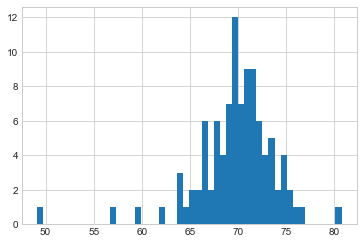

In [52]:
# TEST CASE
true_min = heights['Height'].min()
true_val = heights['Height'].max()
trials = [saa_percentile_height(100, 1.0,0) for _ in range(100)]
   
errors1 = [pct_error(true_val, t) for t in trials]
print('Median error for heights: ', np.median(errors))
errors = [pct_error(true_min, t) for t in trials]


# include histogram for the number of trials
plt.hist(trials, bins =50);

print('Mean error for heights: ', np.mean(errors))
assert np.mean(errors) > 0
assert np.mean(errors) < 11
assert np.median(errors) > 0
assert np.median(errors) < 100

